In [1]:

%matplotlib inline

import warnings

import pandas as pd 
import numpy as np

#visualize
import matplotlib.pyplot as plt
import seaborn as sns

#plotly for interactive visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff 
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

#statistical analysis
import scipy
from scipy.stats import chi2_contingency
from statistics import stdev

from pprint import pprint

#modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score



warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
sns.set_context("notebook")




1. warnings.filterwarnings("ignore"):

   • This line is used to suppress warnings that may be generated during the execution of your code. By setting it to "ignore", any warnings that would normally be displayed will not be shown in the output. This can be useful when you want to keep your output clean or when you are aware of the warnings and have decided they are not relevant for your current analysis.

2. import plotly.figure_factory as ff:

   • This line imports the figure_factory module from the Plotly library and assigns it the alias ff. Plotly is a popular library for creating interactive visualizations in Python. The figure_factory module provides functions to create complex visualizations easily, such as histograms, box plots, and violin plots.

3. init_notebook_mode(connected=True):

   • This line initializes Plotly to work in Jupyter notebooks. The connected=True argument allows Plotly to load the necessary JavaScript and CSS files from the Plotly CDN (Content Delivery Network), enabling interactive plots to be rendered directly within the notebook. This is particularly useful for creating visualizations that users can interact with.

4. sns.set_context("notebook"):

   • This line sets the context for seaborn visualizations. Seaborn is another visualization library built on top of Matplotlib. The set_context("notebook") function adjusts the aesthetics of the plots to be suitable for a Jupyter notebook environment, modifying parameters like font sizes and line widths to enhance readability within that context

In [ ]:
df = pd.read_csv('HR_Employee_Attrition.csv')

print("There are {:,} rows and {} columns in the data.".format(df.shape[0], df.shape[1]))

print("There are {} missing values in the data.".format(df.isnull().sum().sum()))

df.head()

Summary Statistics of numeric variables

In [ ]:
#df.describe()
df


Summary Statistics of categorical variables

In [3]:
cat_cols = df.select_dtypes(include = 'object').columns.tolist()
cat_df = pd.DataFrame(df[cat_cols].melt(var_name = 'column',  value_name = 'value')
                      .value_counts()).rename(columns = {0 : 'count'}).sort_values(by = ['column', 'count'])

display(df.select_dtypes(include = 'object').describe())

display(cat_df)


,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,882,326,673,1470,1054


count
column         value                           
Attrition      Yes                          237
               No                          1233
BusinessTravel Non-Travel                   150
               Travel_Frequently            277
               Travel_Rarely               1043
Department     Human Resources               63
               Sales                        446
               Research & Development       961
EducationField Human Resources               27
               Other                         82
               Technical Degree             132
               Marketing                    159
               Medical                      464
               Life Sciences                606
Gender         Female                       588
               Male                         882
JobRole        Human Resources               52
               Research Director             80
               Sales Representative          83
               Manager                      102
               Healthcare Representative    131
               Manufacturing Director       145
               Laboratory Technician        259
               Research Scientist           292
               Sales Executive              326
MaritalStatus  Divorced                     327
               Single                       470
               Married                      673
Over18         Y                           1470
OverTime       Yes                          416
               No                          1054

In [5]:
df.shape

(1470, 35)



▎1. Selecting categorical columns

cat_cols = df.select_dtypes(include='object').columns.tolist()


• df.select_dtypes(include='object'): This part selects all columns in the DataFrame df that have a data type of 'object'. In pandas, 'object' typically refers to string data.

• .columns.tolist(): This converts the column names of the selected DataFrame into a list. So, cat_cols will contain the names of all categorical columns (string type) in the DataFrame.

▎2. Melting the DataFrame

cat_df = pd.DataFrame(df[cat_cols].melt(var_name='column', value_name='value')
                      .value_counts()).rename(columns={0: 'count'}).sort_values(by=['column', 'count'])


• df[cat_cols]: This selects only the categorical columns from the original DataFrame df.

• .melt(var_name='column', value_name='value'): The melt function transforms the DataFrame from wide format to long format. It creates two new columns:

  • column: This will contain the names of the original categorical columns.

  • value: This will contain the corresponding values from those columns.
  
  Essentially, this means that each unique value from the categorical columns will have its own row, along with the name of the column it came from.

  
• .value_counts(): This counts the occurrences of each unique value in the value column. The result is a Series with unique values as the index and their counts as the values.

  
• pd.DataFrame(...): This converts the Series obtained from value_counts() into a DataFrame.

  
• .rename(columns={0: 'count'}): This renames the first column (which contains counts) to 'count'.

  
• .sort_values(by=['column', 'count']): Finally, this sorts the DataFrame first by the 'column' name and then by 'count'.

▎3. Displaying descriptive statistics for categorical columns

display(df.select_dtypes(include='object').describe())


• df.select_dtypes(include='object'): Again, this selects all categorical columns (string type) from the DataFrame.

• .describe(): This function provides summary statistics for categorical columns, including counts, unique values, top (most frequent) values, and their frequency.

• display(...): This is typically used in Jupyter notebooks to display the DataFrame in a more readable format.

▎4. Displaying the melted DataFrame

display(cat_df)


• This simply displays the newly created DataFrame cat_df, which contains counts of unique values for each categorical column.

▎Summary

In summary:

• The code extracts all categorical columns from a DataFrame, transforms them into a long format to count occurrences of unique values, and then displays both summary statistics for these columns and the resulting counts in a new DataFrame. This is useful for understanding the distribution of categorical data in your dataset.

**Exploratory Data Analysis**

In [6]:
plot_df = df['Attrition'].value_counts(normalize=True)

plot_df = plot_df.mul(100).rename('Percent').reset_index().sort_values('Percent')

plot_df

,Attrition,Percent
1,Yes,16.122449
0,No,83.877551


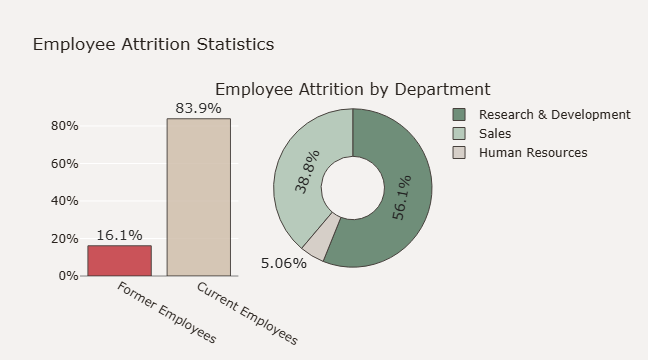

In [7]:
fig = make_subplots(rows=1, cols=2, 
                  subplot_titles=("", "Employee Attrition by Department"),
                  specs=[[{"type": "bar"}, {"type": "pie"}]])

# Bar chart
plot_df = df['Attrition'].value_counts(normalize=True)
plot_df = plot_df.mul(100).rename('Percent').reset_index().sort_values('Percent')
plot_df.rename(columns={'index':'Attrition'}, inplace=True)
plot_df['Attrition']=['Former Employees' if i == 'Yes' else 'Current Employees' for i in plot_df['Attrition']]
x=plot_df['Attrition']
y=plot_df['Percent']
fig.add_trace(
    go.Bar(x=x, y=y, text= y, opacity=.8,
           hovertemplate='Employee Attrition Rate<br>%{x}: %{y:.3}%<extra></extra>',
           showlegend=False), row=1, col=1)
fig.update_traces(texttemplate='%{text:.3s}%', textposition = 'outside', 
                  marker_line=dict(width=1, color='#1F0202'), marker_color=['#C02B34','#CDBBA7'])
fig.update_yaxes(zeroline = True, zerolinewidth = 1, zerolinecolor = 'gray')
fig.update_layout(yaxis_ticksuffix = '%')

# Pie chart
plot_df2 = df[df.Attrition=='Yes']
plot_df2 = plot_df2['Department'].value_counts(normalize=True)
plot_df2=plot_df2.mul(100).rename('Percent').reset_index().sort_values('Percent', ascending=False)
plot_df2.rename(columns={'index':'Department'}, inplace=True)
fig.add_trace(go.Pie(labels=plot_df2['Department'], values = plot_df2['Percent'], opacity=0.85, hole=0.4,
                     hovertemplate='%{label}<br>Attrition Rate: %{value:.3}%<extra></extra>',
                     marker_colors=['#587D65','#ADC4B2','#D1C9C2']), row=1, col=2)
fig.update_yaxes(tickmode = 'array', range = [0, max(y) + 10], dtick=5)
fig.update_traces(textfont_size=14,textfont_color='black',marker=dict(line=dict(color='#28221D', width=1)))
fig.update_layout(title_text="Employee Attrition Statistics", font_color='#28221D',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')      
fig.show()

In [8]:
df.shape

(1470, 35)

This small dashboard shows the attrition rates among employees in the previous quarter. Overall, around 16% of employees left the company. Among former employees, over half worked in Research & Development, while only 5% were from Human Resources.

In [ ]:
plot_df = df.groupby(['Gender','Department'])['Attrition'].value_counts(normalize=True)
plot_df = plot_df.mul(100).rename('Percent').reset_index()
plot_df

In [9]:
plot_df = df.groupby(['Gender','Department'])['Attrition'].value_counts(normalize = True)
plot_df = plot_df.mul(100).rename('Percent').reset_index()
fig = px.bar(plot_df, x="Department", y="Percent", color = "Attrition", barmode="group",
            text='Percent', opacity=.75, facet_col="Gender", category_orders={'Attrition': ['Yes', 'No']},
            color_discrete_map={'Yes': '#C02B34','No': '#CDBBA7'}) 
fig.update_traces(texttemplate='%{text:.3s}%', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'),  width=.4)
fig.update_layout(title_text='Attrition Rates by Department and Gender', yaxis_ticksuffix = '%',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0',font_color='#28221D',
                  height=500, xaxis=dict(tickangle=30))
fig.update_xaxes(showticklabels=True,tickangle=30,col=2)
fig.update_yaxes(title = "", zeroline = True, zerolinewidth = 1, zerolinecolor = '#28221D')
fig.show()

Women in Human Resources experienced the highest amount of turnover, with nearly 1 out of every 3 women in HR leaving the company. For men, the highest turnover occurred in the Sales department.

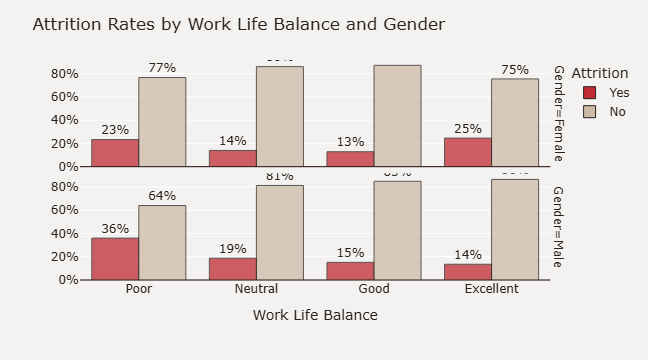

In [10]:
plot_df = df.groupby(['WorkLifeBalance','Gender'])['Attrition'].value_counts(normalize=True)
plot_df = plot_df.mul(100).rename('Percent').reset_index()
fig = px.bar(plot_df, x='WorkLifeBalance', y='Percent', color='Attrition',
             facet_row='Gender', text='Percent', opacity=0.75, barmode='group', 
             category_orders={'Attrition': ['Yes', 'No']},
             color_discrete_map={'Yes': '#C02B34','No': '#CDBBA7'})
fig.update_traces(texttemplate='%{text:.2s}%', textposition='outside', 
                  marker_line=dict(width=1, color='#28221D'))
fig.update_yaxes(title="",zeroline=True, zerolinewidth=1, zerolinecolor='#1F0202',ticksuffix = '%')
fig.update_layout(title_text='Attrition Rates by Work Life Balance and Gender',height=750,font_color='#28221D',
                  xaxis_title='Work Life Balance', paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0', 
                  xaxis = dict(tickmode = 'array', tickvals = [1, 2, 3, 4],
                               ticktext = ['Poor', 'Neutral', 'Good', 'Excellent']))
fig.show()

Among women with the highest rated work life balance, 1 out of 4 left the company, the highest proportion among the ratings for women. For men, the highest proportion occurred in those with the lowest work life balance

In [11]:
plot_df = df.groupby(['Attrition'])['JobSatisfaction'].value_counts(normalize=True)
plot_df = plot_df.mul(100).rename('Percent').reset_index().sort_values('JobSatisfaction')
plot_df.JobSatisfaction = pd.Categorical(plot_df.JobSatisfaction).rename_categories(
    {1:'Poor', 2:'Neutral', 3:'Good', 4:'Excellent'})
plot_df

,Attrition,JobSatisfaction,Percent
3,No,Poor,18.085969
5,Yes,Poor,27.848101
2,No,Neutral,18.978102
7,Yes,Neutral,19.409283
1,No,Good,29.927007
4,Yes,Good,30.801688
0,No,Excellent,33.008921
6,Yes,Excellent,21.940928


In [99]:
df.shape

(1470, 35)

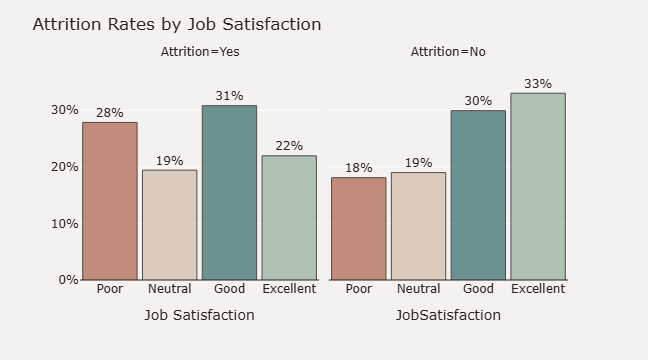

In [12]:

plot_df = df.groupby(['Attrition'])['JobSatisfaction'].value_counts(normalize=True)
plot_df = plot_df.mul(100).rename('Percent').reset_index().sort_values('JobSatisfaction')
plot_df.JobSatisfaction = pd.Categorical(plot_df.JobSatisfaction).rename_categories(
    {1:'Poor', 2:'Neutral', 3:'Good', 4:'Excellent'})
fig = px.bar(plot_df, x='JobSatisfaction', y='Percent', text='Percent', opacity=0.8,
             facet_col="Attrition", category_orders={"Attrition": ["Yes", "No"]})
fig.update_traces(texttemplate='%{text:.2s}%', textposition='outside', 
                  marker_color=['#B6735F', '#D7C2B0', '#497B7A', '#9EB5A3'],
                  marker_line=dict(width=1, color='#28221D'))
fig.update_yaxes(title="",zeroline=True, zerolinewidth=1, zerolinecolor='#28221D', ticksuffix='%')
fig.update_yaxes(range = [0, max(y)-45])
fig.update_layout(title_text='Attrition Rates by Job Satisfaction', bargap=.09,font_color='#28221D',
                  xaxis_title = 'Job Satisfaction',paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')
fig.show()

Among employees who left, the majority were satisfied in their job with 53% rating their job satisfaction as Good or Excellent, while 28% were the least satisfied in their job.

In [13]:
plot_df = df.groupby(['Department', 'Gender'])['MonthlyIncome'].mean()
plot_df = plot_df.mul(12).rename('Salary').reset_index().sort_values('Salary', ascending=False)
plot_df

,Department,Gender,Salary
0,Human Resources,Female,87168.000000
4,Sales,Female,83665.523810
5,Sales,Male,83395.750973
2,Research & Development,Female,78164.295515
1,Human Resources,Male,76452.279070
3,Research & Development,Male,73558.659794


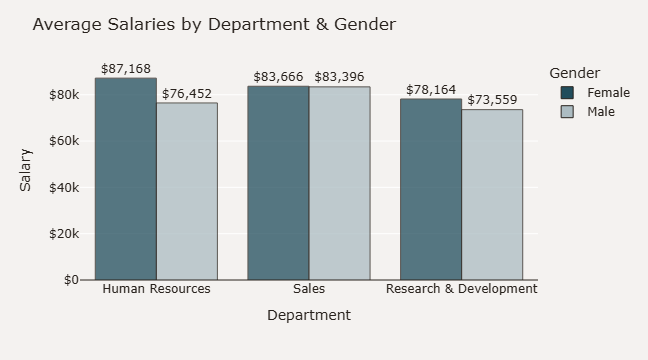

In [13]:
plot_df = df.groupby(['Department', 'Gender'])['MonthlyIncome'].mean()
plot_df = plot_df.mul(12).rename('Salary').reset_index().sort_values('Salary', ascending=False)
fig = px.bar(plot_df, x='Department', y='Salary', color='Gender', text='Salary'  
            ,barmode='group' , opacity=0.75, color_discrete_map={'Female': '#214D5C','Male': '#ACBCC2'})
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'))
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='#28221D')
fig.update_layout(title_text='Average Salaries by Department & Gender', font_color='#28221D',
                  yaxis=dict(title='Salary',tickprefix='$'), paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')
fig.update_yaxes(range = [0, 95000])
fig.show()

Across each department, women on average have higher salaries than men

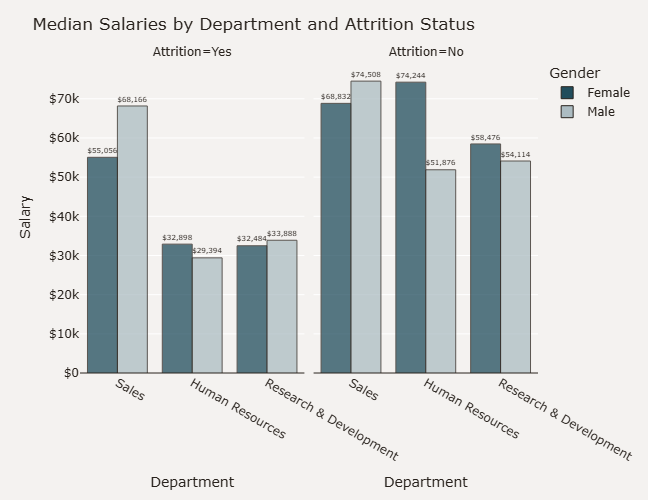

In [14]:

plot_df = df.groupby(['Department', 'Attrition', 'Gender'])['MonthlyIncome'].median()
plot_df = plot_df.mul(12).rename('Salary').reset_index().sort_values('Salary', ascending=False).sort_values('Gender')
fig = px.bar(plot_df, x='Department', y='Salary', color='Gender', text='Salary',  
             barmode='group', opacity=0.75, color_discrete_map={'Female': '#214D5C','Male': '#ACBCC2'},
             facet_col='Attrition', category_orders={'Attrition': ['Yes', 'No']})
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'))
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='#28221D')
fig.update_layout(title_text='Median Salaries by Department and Attrition Status', font_color='#28221D',
                  yaxis=dict(title='Salary',tickprefix='$',range=(0,79900)),width=600,height=500,
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')

fig.show()

In comparison to current employees, former employees had lower median salaries across all three departments. In Human Resources, women tend to have higher median salaries than men.

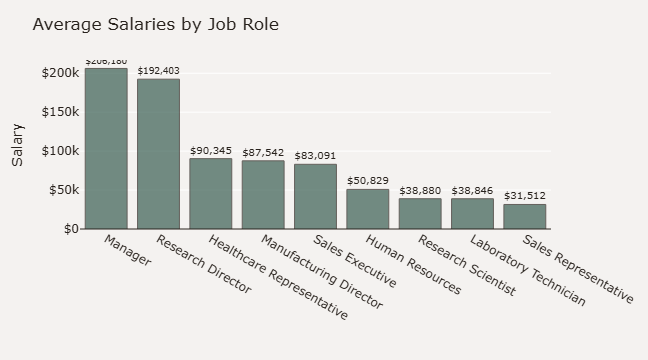

In [15]:
plot_df = df.groupby('JobRole')['MonthlyIncome'].mean()
plot_df = plot_df.mul(12).rename('Salary').reset_index().sort_values('Salary', ascending=False)
fig = px.bar(plot_df, x='JobRole', y='Salary', text='Salary', opacity=0.7)
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'), marker_color='#3A5F53')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='#28221D')
fig.update_layout(title_text='Average Salaries by Job Role', font_color='#28221D',
                  yaxis=dict(title='Salary',tickprefix='$'), height=450,
                  xaxis_title='', paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')
fig.show()

Managers and Research Directors have the highest average salaries, while Laboratory Technicians and Sales Representatives have the lowest.

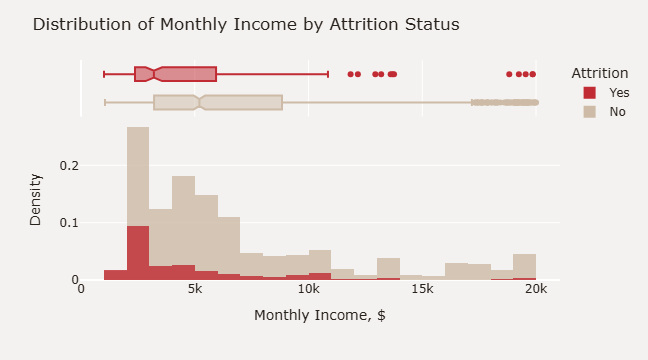

In [16]:
plot_df = df.sort_values(by="Attrition")
fig = px.histogram(plot_df, x = 'MonthlyIncome', color = 'Attrition', 
                 opacity = 0.8, histnorm = 'density', barmode='overlay', marginal='box',
                 color_discrete_map = {'Yes' : '#C02B34','No' : '#CDBBA7'})
fig.update_layout(title_text = 'Distribution of Monthly Income by Attrition Status',
                  xaxis_title = 'Monthly Income, $', yaxis_title='Density',font_color='#28221D',
                  paper_bgcolor = '#F4F2F0', plot_bgcolor='#F4F2F0', legend_traceorder = 'reversed')
fig.show()

The distribution of monthly income for both current and former employees is positively skewed and lower overall among staff who left. Former employees had a median monthly income more than $2,000 less than current employees

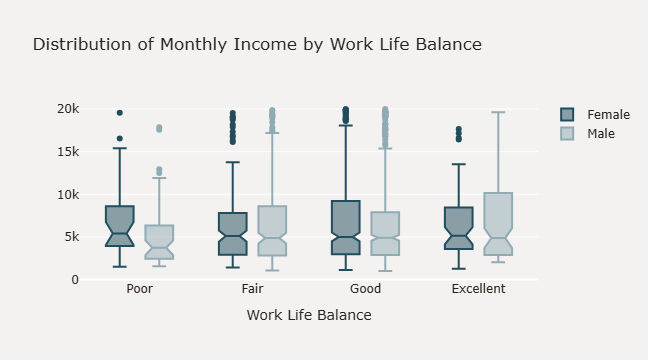

In [17]:

fig = go.Figure()
colors = ['#214D5C','#91ABB4']
for i, j in enumerate(df['Gender'].unique()):
    df_plot=df[df['Gender']==j]
    fig.add_trace(go.Box(x=df_plot['WorkLifeBalance'], y=df_plot['MonthlyIncome'],
                         notched = True, line=dict(color=colors[i]), name=j))
fig.update_layout(title='Distribution of Monthly Income by Work Life Balance',
                  xaxis_title='Work Life Balance', boxmode='group', font_color='#28221D',
                  xaxis = dict(tickmode = 'array', tickvals = [1, 2, 3, 4],
                               ticktext = ['Poor', 'Fair', 'Good', 'Excellent']),
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')
fig.show()

Women with the lowest-rated work life balance have the highest median salary out of all of the groups at $5,400/month.

(1470, 14)

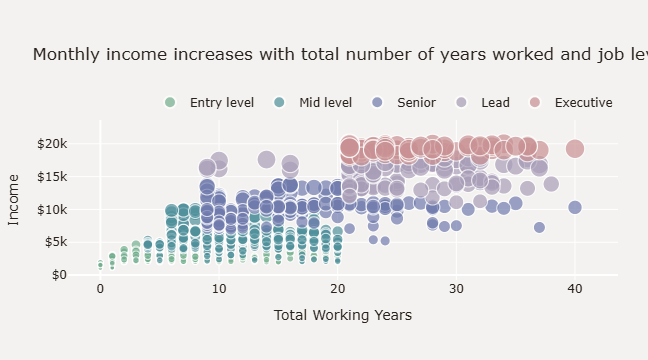

In [18]:
plot_df = df.copy()
plot_df['JobLevel'] = pd.Categorical(
    plot_df['JobLevel']).rename_categories( 
    ['Entry level', 'Mid level', 'Senior', 'Lead', 'Executive'])
col=['#73AF8E', '#4F909B', '#707BAD', '#A89DB7','#C99193']
fig = px.scatter(plot_df, x='TotalWorkingYears', y='MonthlyIncome', 
                 color = 'JobLevel', size='MonthlyIncome',
                 color_discrete_sequence = col, 
                 category_orders={'JobLevel': ['Entry level', 'Mid level', 'Senior', 'Lead', 'Executive']})
fig.update_layout(legend=dict(orientation = "h", yanchor = "bottom", y=1.02, xanchor="right", x=1),
                  title='Monthly income increases with total number of years worked and job level <br>',
                  xaxis_title='Total Working Years', yaxis=dict(title='Income',tickprefix='$'), 
                  legend_title='', font_color='#28221D',
                  margin=dict(l=40, r=30, b=80, t=120), paper_bgcolor = '#F4F2F0', plot_bgcolor='#F4F2F0')
fig.show()

Based on the scatterplot above, monthly income is positively correlated with total number of years worked and there is strong association between an employee's earnings and their job level.

In [19]:
df.shape

(1470, 35)

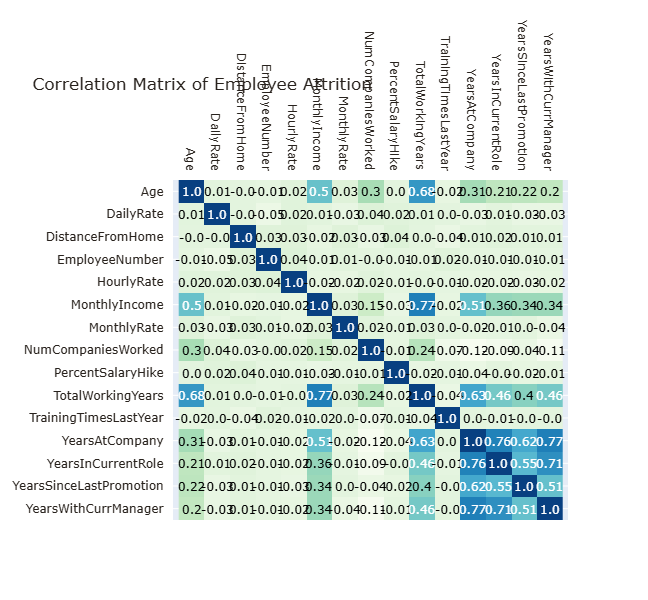

In [4]:
cat_cols=[]
for i in df.columns:
    if df[i].nunique() <= 5 or df[i].dtype == object:
        cat_cols.append(i)
df_=df.copy()
df_.drop(df_[cat_cols], axis=1, inplace=True)
corr=df_.corr().round(2)
x = corr.index.tolist()
y = corr.columns.tolist()
z = corr.to_numpy()#changing df values to numpy arrays
fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=z, name='',
                                  hovertemplate="Correlation between %{x} and %{y}= %{z}",
                                  colorscale='GnBu')
fig.update_yaxes(autorange="reversed")
fig.update_layout(title="Correlation Matrix of Employee Attrition", 
                  font_color='#28221D',margin=dict(t=180),height=600)
fig.show()

Confirming our findings in the scatterplot above, MonthlyIncome has a strong positive correlation to TotalWorkingYears of 0.77. Additionally, YearsAtCompany has a strong positive association with YearsWithCurrManager (correlation = 0.77), as well as with YearsInCurrentRole (correlation = 0.76). There are no variables with a correlation above 0.8, indicating a potential collinearity issue.

**Data Cleaning and Preprocessing**

There are several columns in the data that have numeric values that represent categories, like Education that has values of 1 through 5 representing different levels of education. These columns were converted to categorical variables to perform significance testing for feature selection. I then removed columns with zero variance from the data since these can lead to errors in model fitting. Lastly, to reduce the skewness in the data, I log-transformed variables that had a skewness above 0.75.

In [21]:
 d=pd.factorize(df['Attrition'])
d

(array([0, 1, 0, ..., 1, 1, 1], dtype=int64),
 Index(['Yes', 'No'], dtype='object'))

In [5]:
# Checking for variables with 0 variance
norm_df=df.copy()
nzv=[]
for i in norm_df[cat_cols]:
    norm_df[i]=pd.factorize(norm_df[i])[0]#encode and get encoded values not index too
for i in norm_df.columns:
    if stdev(norm_df[i]) == 0.0:
        nzv.append(i)

# Converting cols to category
for i in df[cat_cols]:
    if i=='Attrition':
        continue
    df[i] = pd.Categorical(df[i])

# Removing variables with 0 variance and Employee Number
print("Dropping variables with zero variance:", nzv)
df.drop(df[nzv], axis=1, inplace=True)
df.drop('EmployeeNumber', axis=1, inplace=True)
data = df.copy()
data.shape

Dropping variables with zero variance: ['EmployeeCount', 'Over18', 'StandardHours']


(1470, 31)

In [25]:
data.dtypes

Age                            int64
Attrition                     object
BusinessTravel              category
DailyRate                      int64
Department                  category
DistanceFromHome             float64
Education                   category
EducationField              category
EnvironmentSatisfaction     category
Gender                      category
HourlyRate                     int64
JobInvolvement              category
JobLevel                    category
JobRole                     category
JobSatisfaction             category
MaritalStatus               category
MonthlyIncome                float64
MonthlyRate                    int64
NumCompaniesWorked           float64
OverTime                    category
PercentSalaryHike            float64
PerformanceRating           category
RelationshipSatisfaction    category
StockOptionLevel            category
TotalWorkingYears            float64
TrainingTimesLastYear          int64
WorkLifeBalance             category
Y

In [6]:
# Check for variables with skew above 0.75
dt = data.select_dtypes(include = 'number')
skew_limit = 0.75
skew_vals = dt.skew()
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

display(skew_cols.style.set_caption('Columns to be log-transformed:'))


# Log-transform skewed variables
for i in skew_cols.index.values:
    data[i] = data[i].apply(np.log1p)


,Skew
YearsSinceLastPromotion,1.984290
YearsAtCompany,1.764529
MonthlyIncome,1.369817
TotalWorkingYears,1.117172
NumCompaniesWorked,1.026471
DistanceFromHome,0.958118
YearsInCurrentRole,0.917363
YearsWithCurrManager,0.833451
PercentSalaryHike,0.821128


 **Hypothesis Testing**

I. Independent T-Test

To compare the average monthly income among current and former employees, I'll perform an independent t-test. This will allow us to determine whether there is a statistically significant difference between the average incomes of the two populations. To test this, I'll use the log-transformed data since one of the assumptions of the test is that the continuous variable is approximately normally distributed.

Hypothesis:
H0
: The null hypothesis for the t-test is that the average monthly income of former employees is the same as current employees.
u1=u2

H1
: The alternative hypothesis is that the average monthly income of former employees is different than current employees.
u1≠u2

In [7]:
import researchpy as rp
summary, res=rp.ttest(group1=data['MonthlyIncome'][data['Attrition']=='Yes'], 
                      group2=data['MonthlyIncome'][data['Attrition']=='No'], 
                      group1_name='Former Employees', group2_name='Current Employees')
print("\nSummary Statistics:")
display(summary)
display(res)


Summary Statistics:


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Former Employees,237.0,8.252532,0.640059,0.041576,8.170624,8.334440
1,Current Employees,1233.0,8.610458,0.653497,0.018611,8.573946,8.646970
2,combined,1470.0,8.552752,0.664313,0.017327,8.518764,8.586739


,Independent t-test,results
0,Difference (Former Employees - Current Employe...,-0.3579
1,Degrees of freedom =,1468.0000
2,t =,-7.7477
3,Two side test p value =,0.0000
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-0.5495
7,Hedge's g =,-0.5492
8,Glass's delta1 =,-0.5592
9,Point-Biserial r =,-0.1982


The p-value of the T-Test is 0, which is less than our significance level,  
a
 , of 0.05. Therefore, there is evidence to support that the average monthly income of former employees is different than the average monthly income of current employees.

II. Chi-Square Test of Independence

To determine if there is a relationship between Attrition and the other categorical variables in the data set, I will use the chi-square test of independence. The null hypothesis for this test is that the variables are independent, there is no association between Attrition and the variable being tested, while the alternative hypothesis is that that there is a relationship.

In [8]:
cat_cols=data.select_dtypes(include="category").columns.tolist() 
chi_statistic=[]
p_val=[]
vars_rm=[]

for i in data[cat_cols]:
    observed=pd.crosstab(index=data["Attrition"], columns=data[i])
    stat, p, dof, expected=chi2_contingency(observed)
    chi_statistic.append(stat)
    p_val.append(p)
    if p >= 0.05:
        print("Attrition and {} are independent (p-value = {:.2f}).\n".format(i,p))
        vars_rm.append(i)

chi_df = pd.DataFrame()
chi_df["Variable"] = cat_cols
chi_df["Chi_Statistic"] = chi_statistic
chi_df["P_value"] = p_val
chi_df=chi_df[chi_df.P_value<0.05].sort_values("P_value", ascending=True)
display(chi_df)

Attrition and Education are independent (p-value = 0.55).

Attrition and Gender are independent (p-value = 0.29).

Attrition and PerformanceRating are independent (p-value = 0.99).

Attrition and RelationshipSatisfaction are independent (p-value = 0.15).



,Variable,Chi_Statistic,P_value
11,OverTime,87.564294,8.158424e-21
8,JobRole,86.190254,2.752482e-15
7,JobLevel,72.529013,6.634685e-15
14,StockOptionLevel,60.598301,4.379390e-13
10,MaritalStatus,46.163677,9.455511e-11
6,JobInvolvement,28.492021,2.863181e-06
0,BusinessTravel,24.182414,5.608614e-06
4,EnvironmentSatisfaction,22.503881,5.123469e-05
9,JobSatisfaction,17.505077,5.563005e-04
15,WorkLifeBalance,16.325097,9.725699e-04


In [38]:
# Assuming cat_cols is a list of your categorical column names
for col in cat_cols:
    unique_values = data[col].unique()
    print(f"Unique values in '{col}': {unique_values}")


Unique values in 'BusinessTravel': ['Travel_Rarely', 'Travel_Frequently', 'Non-Travel']
Categories (3, object): ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']
Unique values in 'Department': ['Sales', 'Research & Development', 'Human Resources']
Categories (3, object): ['Human Resources', 'Research & Development', 'Sales']
Unique values in 'Education': [2, 1, 4, 3, 5]
Categories (5, int64): [1, 2, 3, 4, 5]
Unique values in 'EducationField': ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources']
Categories (6, object): ['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other', 'Technical Degree']
Unique values in 'EnvironmentSatisfaction': [2, 3, 4, 1]
Categories (4, int64): [1, 2, 3, 4]
Unique values in 'Gender': ['Female', 'Male']
Categories (2, object): ['Female', 'Male']
Unique values in 'JobInvolvement': [3, 2, 4, 1]
Categories (4, int64): [1, 2, 3, 4]
Unique values in 'JobLevel': [2, 1, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4,

Based on the chi square test results, factors that are significant in whether an employee stays at the company include their work life balance, job satisfation, whether or not they work overtime, their stock options, and the department they work in. Variables that are independent of attrition, like Education, Gender, PerformanceRating, and RelationshipSatisfaction, will be removed from the predictors in the model.

Predicting Employee Attrition

In [42]:
y=data['Attrition'].apply(lambda x: 1 if x=='Yes' else 0)
X=data.loc[:, df.columns != 'Attrition']
X.drop(X[vars_rm], axis=1, inplace=True)
x = X.select_dtypes(include = 'category')
x.columns

Index(['BusinessTravel', 'Department', 'EducationField',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'OverTime', 'StockOptionLevel',
       'WorkLifeBalance'],
      dtype='object')

In [28]:
y=data['Attrition'].apply(lambda x: 1 if x=='Yes' else 0)
X=data.loc[:, df.columns != 'Attrition']
X.drop(X[vars_rm], axis=1, inplace=True)

X=pd.get_dummies(X, columns=chi_df.Variable.values, dtype = int)
X.columns=X.columns.str.replace(' ', '')



(1470, 65)

II. Create Training, Validation, and Test Sets

In [29]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=21)

print("Train Shape:", X_train.shape, y_train.shape)
print("Validation set Shape:", X_val.shape,y_val.shape)
print("Test set Shape:", X_test.shape, y_test.shape)

Train Shape: (1029, 65) (1029,)
Validation set Shape: (220, 65) (220,)
Test set Shape: (221, 65) (221,)


III. Scale Features

In [40]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)




Age                                 int64
DailyRate                           int64
DistanceFromHome                  float64
HourlyRate                          int64
MonthlyIncome                     float64
                                   ...   
EducationField_LifeSciences         int32
EducationField_Marketing            int32
EducationField_Medical              int32
EducationField_Other                int32
EducationField_TechnicalDegree      int32
Length: 65, dtype: object

IV. Tune Parameters of Random Forest

In [31]:

# Parameter tuning
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'max_features': [None, 'sqrt'],
        'max_depth': [None, 5, 7, 14, 21],
        'min_samples_split': [2, 5, 8],
        'min_samples_leaf': [3, 4, 5],
        'bootstrap': [True, False]}

rf=RandomForestClassifier(random_state=92)
rf_cv=RandomizedSearchCV(estimator=rf, param_distributions=grid, scoring='roc_auc', 
                         n_iter=100, cv=5, random_state=92, n_jobs=-1)
rf_cv.fit(X_train, y_train)
print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(rf_cv.best_score_, rf_cv.best_estimator_))

Grid Search CV Best AUC = 0.800
Best Params: RandomForestClassifier(max_depth=7, min_samples_leaf=4, n_estimators=200,
                       random_state=92)


In [32]:
import joblib

model  = rf_cv.best_estimator_

joblib.dump(model, 'C:/Users/HP/OneDrive/Documents/DS_data/models/model.pkl')

['C:/Users/HP/OneDrive/Documents/DS_data/models/model.pkl']

V. Feature importance

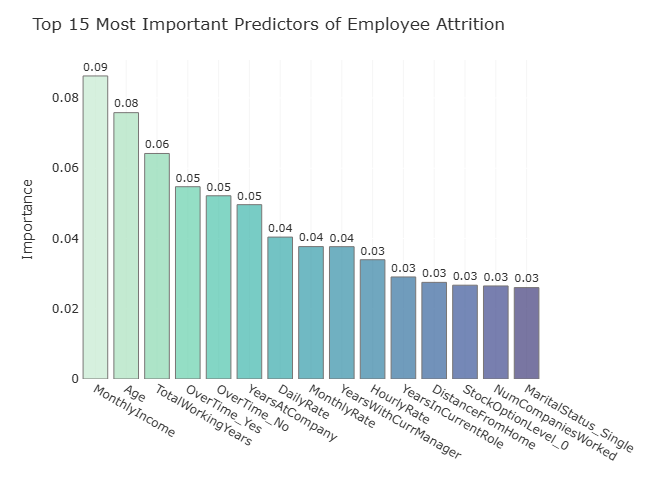

In [33]:
col=sns.color_palette("mako", 20).as_hex()[::-1]
feat=pd.DataFrame({"Importance": rf_cv.best_estimator_.feature_importances_}, index=X_train.columns
                 ).sort_values(by="Importance")
plot_df=feat.nlargest(15, columns='Importance').sort_values(by="Importance", ascending=False)
fig = px.bar(plot_df, x=plot_df.index, y='Importance', text='Importance', 
             color=plot_df.index, opacity=0.7, color_discrete_sequence=col)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside',
                  marker_line=dict(width=1, color='#3F3B3A'), 
                  hovertemplate='%{x}<br>Importance = %{y:.2f}')
fig.update_layout(title_text='Top 15 Most Important Predictors of Employee Attrition', 
                  coloraxis_showscale=False, showlegend=False,font_color="#303030", height = 500,
                  paper_bgcolor='white', plot_bgcolor='white', yaxis_title="Importance", 
                  xaxis = dict(title="", showgrid=True, gridcolor="#f5f5f5"))
fig.show()

This bar graph shows the most important variables in predicting employee attrition using random forest's Gini importance measure. Variable importance is calculated by the decrease in the tree node's impurity from splitting on that feature, averaged over all of the trees in the model. Based on this graph, monthly income, age, and working overtime are the most important predictors of employee attrition. In addition, information related to their job history, like the total number of years they've worked and the length of time they've been with the company and with their current manager, as well as their proximity to the office and salary rate increases are some of the most important contributors in predicting employee attrition.

VI. Model evaluation

In [34]:
val_auc=roc_auc_score(y_val, rf_cv.predict_proba(X_val)[:,1])
test_auc=roc_auc_score(y_test, rf_cv.predict_proba(X_test)[:,1])
val_acc=accuracy_score(y_val, rf_cv.predict(X_val))
test_acc=accuracy_score(y_test, rf_cv.predict(X_test))
print("Validation Accuracy: {:.1f}% and AUC = {:.3f}".format(val_acc*100, val_auc))
print("Test set Accuracy: {:.1f}% and AUC = {:.3f}".format(test_acc*100, test_auc))

Validation Accuracy: 84.5% and AUC = 0.803
Test set Accuracy: 84.2% and AUC = 0.819


Conclusion

In this analysis, we found that 16% of employees left the company in the previous quarter, with more than half leaving from the Research & Development department. Among women, the highest turnover occurred in the Human Resources department. About 1 in every 4 workers with the lowest work-life balance left the company, though the majority of employees who left rated their job satisfaction as good or excellent. Among former employees, salary was found to be significantly lower, with a median monthly income about $2,000/month less than current employees. Variables that were found not to be significant in whether an employee left include their education level, performance rating, and gender.

Based on the feature importances from the Random Forest model, an employee's age, income, tenure and job history with the company were among the most influential predictors of employee attrition. With these features, our model was able to predict the likelihood of an employee leaving the company with an Area Under the Curve of 0.774 on the validation set and 0.816 on the test set. To further improve on the model, additional data on employees who left or using weighted sampling methods could be used to help with handling the class imbalance in our data